In [69]:
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
plt.style.use('fivethirtyeight')

# <font face="gotham" color="orange"> Simple Linear Regression</font>

This is a simple linear regression model as in every textbooks
$$
Y_i=\beta_1+\beta_2X_i+u_i\qquad i = 1, 2, ..., n
$$
where $Y$ is **dependent variable**, $X$ is **independent variable** and $u$ is **disturbance term**. $\beta_1$ and $\beta_2$ are unknown parameters that we are aiming to estimate by feeding the data in the model. 

Following Gauss-Markov assumptions,
$$
E(Y|X_i) = {\beta}_1 + {\beta}_2X_i\\
Y_{i} \sim \mathrm{N}\left({\beta_{1}}+{\beta_{2}}X_{i}, \sigma^{2}\right)
$$
Similarly, the precision is defined as $\tau=\frac{1}{\sigma^2}$.

## <font face="gotham" color="orange"> The Priors</font>

Each of these three parameters, i.e. $\beta_1$, $\beta_2$ and $\tau$ will be estimated, therefore each of them have their own **prior elicitation** which means define a prior with all proper knowledge available. For demonstration purpose, we define $\beta$ priors as normal distributions.

$$
P(\beta_1)=(2 \pi)^{-\frac{1}{2}} \tau_1^{\frac{1}{2}} \exp{\left(-\frac{1}{2} \tau_1 \left(\beta_1-\mu_1\right)^{2}\right)}\\
P(\beta_2)=(2 \pi)^{-\frac{1}{2}} \tau_2^{\frac{1}{2}} \exp{\left(-\frac{1}{2} \tau_2 \left(\beta_1-\mu_1\right)^{2}\right)}\\
$$

However the precision $\tau$ can't be negative, therefore a Gamma distribution would be appropriate. The posterior of $\tau$ will follow a Gamma distribution too due to **Gamma-Normal conjugate**.
$$
P(\tau)=\frac{\theta_{0}^{\alpha_{0}} \tau^{\alpha_{0}-1} e^{-\theta_{0} \tau}}{\Gamma\left(\alpha_{0}\right)} \quad 0 \leq \tau \leq \infty
$$

## <font face="gotham" color="orange"> Likelihood Function</font>

With normality assumption, likelihood of $Y$ is
$$
\mathcal{L}\left(Y | \mu_{i}, \sigma^{2}\right)=\prod_{i=1}^n\frac{1}{\sigma \sqrt{2 \pi}} \exp{\left(-\frac{1}{2}\left(\frac{Y_i-\mu_i}{\sigma}\right)^{2}\right)}
$$

Equivalently, replace $\sigma$ by $\tau$ and rewrite the function into summation
$$
\mathcal{L}\left(Y | \mu_{i}, \tau\right)=(2 \pi)^{-\frac{n}{2}} \tau^{\frac{n}{2}} \exp{\left(-\frac{1}{2} \tau \sum_{i=1}^n\left(Y_{i}-\mu_{i}\right)^{2}\right)}
$$

Replace $\mu_i$ by ${\beta}_1 + {\beta}_2X_i$, note how we have change the notation of parameters
$$
\mathcal{L}\left(Y | \beta_1, \beta_2, \tau\right)=(2 \pi)^{-\frac{n}{2}} \tau^{\frac{n}{2}} \exp{\left(-\frac{1}{2} \tau \sum_{i=1}^n\left(Y_{i}-({\beta}_1 + {\beta}_2X_i)\right)^{2}\right)}
$$

The likelihood function are the same for $\beta_1$, $\beta_2$ and $\tau$.
$$
\mathcal{L}\left(Y | \beta_1\right)=\mathcal{L}\left(Y | \beta_2\right)=\mathcal{L}\left(Y | \tau\right)=(2 \pi)^{-\frac{n}{2}} \tau^{\frac{n}{2}} \exp{\left(-\frac{1}{2} \tau \sum_{i=1}^n\left(Y_{i}-({\beta}_1 + {\beta}_2X_i)\right)^{2}\right)}
$$

## <font face="gotham" color="orange"> The Posteriors </font>

Be careful about the notation, $\tau_1$ is the precision of $\beta_1$ which is a variable rather than a constant viewed in frequentists. 

To start from $\beta_1$
$$
P\left(\beta_{1}\right) \times P\left(Y\mid \beta_{1}\right)=(2 \pi)^{-\frac{1}{2}} \tau_{1}^{\frac{1}{2}} \exp\left({-\frac{\tau_{1}}{2}\left(\beta_{1}-\mu_{1}\right)^{2}}\right) \times (2 \pi)^{-\frac{n}{2}} \tau^{\frac{n}{2}} \exp{\left(-\frac{1}{2} \tau \sum_{i=1}^n\left(Y_{i}-({\beta}_1 + {\beta}_2X_i)\right)^{2}\right)}
$$

Join terms
$$
P\left(\beta_{1}\right) \times P\left(Y\mid \beta_{1}\right)=(2 \pi)^{-\frac{n+1}{2}} \tau_{1}^{\frac{1}{2}} \tau^{\frac{n}{2}} \exp{\left(-\frac{1}{2} \tau_{1}\left(\beta_{1}-\mu_{1}\right)^{2}-\frac{1}{2} \tau \sum_{i=1}^n\left(Y_{i}-\beta_{1}-\beta_{2} X_{i}\right)^{2}\right)}
$$

Let's focus on exponential term for now, expand the brackets
\begin{align}
&\exp{\left(-\frac{1}{2} \tau_{1}\left(\beta_{1}-\mu_{1}\right)^{2}-\frac{1}{2} \tau \sum_{i=1}^n\left(Y_{i}-\beta_{1}-\beta_{2} X_{i}\right)^{2}\right)}\\
&= \exp{\left[-\frac{1}{2} \tau_{1}\left(\beta_{1}^{2}-2 \beta_{1} \mu_{1}+\mu_{1}^{2}\right)-\frac{1}{2} \tau\left(n \beta_{1}^{2}-2 \beta_{1} \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)+\sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)^{2}\right)\right]}\\
&=\exp{\left[-\frac{1}{2}\left(\tau_{1}+n \tau\right) \beta_{1}^{2}-\frac{1}{2}\left[-2 \tau_{1} \mu_{1}-2 \tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right] \beta_{1}-\frac{1}{2} \tau_{1} \mu_{1}^{2}-\frac{1}{2} \tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)^{2}\right]}\\
&=\exp{\left[-\frac{1}{2}\left(\tau_{1}+n \tau\right) \beta_{1}^{2}+\left[\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right] \beta_{1}+\frac{-\frac{1}{2}\left[\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right]^{2}}{\tau_{1}+n \tau}-\frac{-\frac{1}{2}\left[\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right]^{2}}{\tau_{1}+n \tau}-\frac{1}{2} \tau_{1} \mu_{1}^{2}-\frac{1}{2} \tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)^{2}\right]}\\
\end{align}
The first three terms can be combined and the rest are free of $\beta_1$, which will be denoted as $C$.

$$
-\frac{1}{2} \left(\tau_{1}+n \tau\right)\left[\beta_{1}-\frac{\left(\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{\tau_{1}+n \tau}\right]^{2}
$$

Back to Bayes' Theorem
$$
P\left(\beta_{1} | Y\right)=\frac{(2 \pi)^{-\frac{n+1}{2}} \tau_{1}^{\frac{1}{2}} \tau^{\frac{n}{2}} \exp{\left[-\frac{1}{2}\left(\tau_{1}+n \tau\right)\left[\beta_{1}-\frac{\left(\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{\tau_{1}+n \tau}\qquad\right]^{2}+C\right]}}{\int_{-\infty}^{\infty}(2 \pi)^{-\frac{n+1}{2}} \tau_{1}^{\frac{1}{2}} \tau^{\frac{n}{2}} \exp{\left[-\frac{1}{2}\left(\tau_{1}+n \tau\right)\left[u-\frac{\left(\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{\tau_{1}+n \tau}\qquad\right]^{2}+C\right]} d u}
$$

Cancel out terms, we obtain
$$
P\left(\beta_{1} | Y\right)=\frac{\exp{\left[-\frac{1}{2}\left(\tau_{1}+n \tau\right)\left[\beta_{1}-\frac{\left(\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{\tau_{1}+n \tau}\qquad\right]^{2}\right]}}{\int_{-\infty}^{\infty} \exp{\left[-\frac{1}{2}\left(\tau_{1}+n \tau\right)\left[u-\frac{\left(\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{\tau_{1}+n \tau}\qquad\right]^{2}\right]} d u}
$$

Now multiply both numerator and denominator by
$$
\frac{\sqrt{\tau_{1}+n \tau}}{\sqrt{2 \pi}}
$$
which yields

$$
P\left(\beta_{1} | Y\right)=\frac{\frac{\sqrt{\tau_{1}+n \tau}}{\sqrt{2 \pi}}\exp{\left[-\frac{1}{2}\left(\tau_{1}+n \tau\right)\left[\beta_{1}-\frac{\left(\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{\tau_{1}+n \tau}\qquad\right]^{2}\right]}}{\int_{-\infty}^{\infty}\frac{\sqrt{\tau_{1}+n \tau}}{\sqrt{2 \pi}} \exp{\left[-\frac{1}{2}\left(\tau_{1}+n \tau\right)\left[u-\frac{\left(\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{\tau_{1}+n \tau}\qquad\right]^{2}\right]} d u}
$$

The denominator is equal to $1$, which leaves us
$$
P\left(\beta_{1} | Y\right)=(2\pi)^{-\frac{1}{2}}(\tau_1+nr)^{\frac{1}{2}}\exp{\left[-\frac{1}{2}\left(\tau_{1}+n \tau\right)\left[\beta_{1}-\frac{\left(\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{\tau_{1}+n \tau}\qquad\right]^{2}\right]}
$$
Compare with the prior
$$
P(\beta_1)=(2 \pi)^{-\frac{1}{2}} \tau_1^{\frac{1}{2}} \exp{\left(-\frac{1}{2} \tau_1 \left(\beta_1-\mu_1\right)^{2}\right)}
$$

The posterior hyperparameters of $\beta_1$ are
$$
\begin{gathered}
\mu_{\text {1posterior }}=\frac{\tau_{1} \mu_{1}+\tau \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)}{\tau_{1}+n \tau} \\
\tau_{\text {1posterior }}=\tau_{1}+n \tau
\end{gathered}
$$

In [ ]:
def mu_tau_1_post(tau_1_prior, mu_1_prior, mu_2_prior, tau_lh, Y, X, n):
    mu_1_post = (tau_1_prior*mu_1_prior + tau_lh*(np.sum(Y - mu_2_prior*X)))/(tau_1_prior + n*tau_lh)
    tau_1_post = tau_1_prior + n*tau_lh
    sigma_1_post = 1/np.sqrt(tau_1_post)
    return mu_1_post, tau_1_post, sigma_1_post

The derivation of posterior for $\beta_2$ are very, will not be reproduced here
$$
\begin{gathered}
\mu_{2 \text { posterior }}=\frac{\tau_{2} \mu_{2}+\tau \sum_{i=1}^n X_{i}\left(Y_{i}-\beta_{1}\right)}{\tau_{2}+\tau \sum_{i=1}^n X_{i}^{2}} \\
\tau_{2 \text { posterior }}=\tau_{2}+\tau \sum_{i=1}^n X_{i}^{2}
\end{gathered}
$$

In [ ]:
def mu_tau_2_post((tau_2_prior, mu_2_prior, mu_1_prior, tau_lh, Y, X, n)
    mu_2_post = (tau_2_prior*mu_2_prior + tau_lh*np.sum(X*(Y-mu_1_prior)))/(tau_2_prior + tau_lh*np.sum(X**2))
    tau_2_post = tau_2_prior + tau_lh*np.sum(X**2)
    sigma_2_post = 1/np.sqrt(tau_2_post)
    return mu_2_post, tau_2_post, sigma_1_post

We will derive the posterior of $\tau$, prior multiply by likelihood equals
$$
P(\tau)  P(Y | \tau)=\frac{\beta_{0}^{\alpha_{0}} \tau^{\alpha_{0}-1} e^{-\beta_{0} \tau}}{\Gamma\left(\alpha_{0}\right)} *(2 \pi)^{-\frac{n}{2}} \tau^{\frac{n}{2}} \exp{\left[-\frac{1}{2} \tau \Sigma\left(y_{i}-\left(b_{0}-b_{1} x_{i}\right)\right)^{2}\right]}
$$

## <font face="gotham" color="orange"> An Example of Apartment Price </font>

In [2]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', 'CN_Cities_house_price')

In [4]:
df.head()

,cities,house_price,salary
0,Shenzhen,87957,64878
1,Beijing,64721,69434
2,Shanghai,59072,72232
3,Xiamen,49803,58140
4,Guangzhou,39851,68304


The model to fit the data ill be exactly as we derived above, i.e.
$$
Y_i=\beta_1+\beta_2X_i+u_i\qquad i = 1, 2, ..., n
$$

This simple model aims to explain the influence of salary on apartment price per square meter. The $\beta_1$ doesn't have much meaning in the model, literally it means the apartment price when salary equals $0$. However $\beta_2$ has a concrete meaning that how much apartment price can raise based on every one yuan increase in average salary.

We can choose to elicit priors' hyperparameters for $\beta_1$ and $\beta_2$ as 
$$
\mu_1 = 1000\\
\sigma_1 = 200 \qquad \tau_1 = \frac{1}{\sigma_1^2}\\
\mu_2 = 1.5\\
\sigma_2 = .3 \qquad \tau_2 = \frac{1}{\sigma_2^2}\\
$$

$$
\begin{gathered}
\mu_{2 \text { posterior }}=\frac{\tau_{2} \mu_{2}+\tau \sum_{i=1}^n X_{i}\left(Y_{i}-\beta_{1}\right)}{\tau_{2}+\tau \sum_{i=1}^n X_{i}^{2}} \\
\tau_{2 \text { posterior }}=\tau_{2}+\tau \sum_{i=1}^n X_{i}^{2}
\end{gathered}
$$

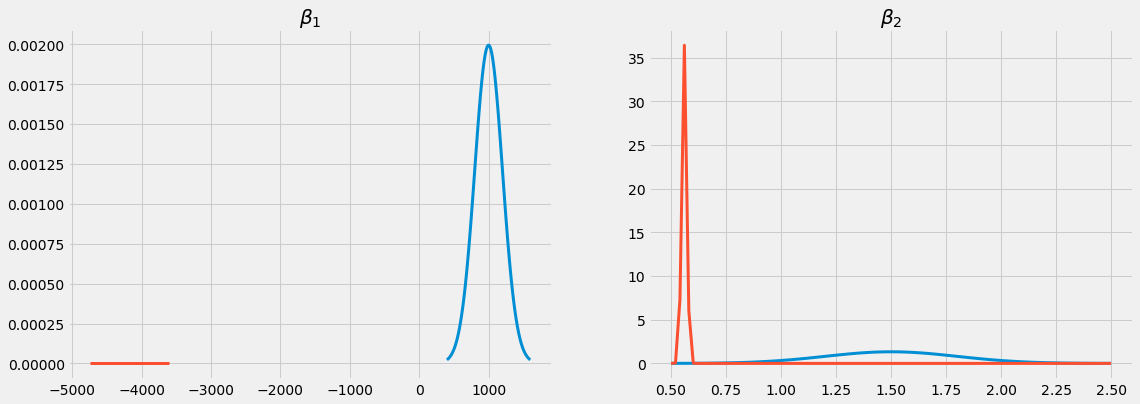

In [73]:
Y, X = df['house_price'], df['salary']

mu_1_prior, sigma_1_prior = 1000, 200
mu_2_prior, sigma_2_prior = 1.5, .3
sigma_lh = 3000
tau_lh = 1/sigma_lh**2
tau_1_prior, tau_2_prior = 1/sigma_1_prior**2, 1/sigma_2_prior**2

betax_prior_1 = np.linspace(400, 1600, 100)
betax_prior_2 = np.linspace(.5, 2.5, 100)

betay_prior_1 = sp.stats.norm.pdf(betax_prior_1, loc=mu_1_prior, scale=sigma_1_prior)
betay_prior_2 = sp.stats.norm.pdf(betax_prior_2, loc=mu_2_prior, scale=sigma_2_prior)
n = len(X)

mu_1_post, tau_1_post, sigma_1_post = 
mu_1_post = (tau_1_prior*mu_1_prior + tau_lh*(np.sum(Y - mu_2_prior*X)))/(tau_1_prior + n*tau_lh)
tau_1_post = tau_1_prior + n*tau_lh
sigma_1_post = 1/np.sqrt(tau_1_post)

mu_2_post = (tau_2_prior*mu_2_prior + tau_lh*np.sum(X*(Y-mu_1_prior)))/(tau_2_prior + tau_lh*np.sum(X**2))
tau_2_post = tau_2_prior + tau_lh*np.sum(X**2)
sigma_2_post = 1/np.sqrt(tau_2_post)

betay_post_1 = sp.stats.norm.pdf(betax_prior_1, loc=mu_1_post, scale=sigma_1_post)
betay_post_2 = sp.stats.norm.pdf(betax_prior_2, loc=mu_2_post, scale=sigma_2_post)



fig, ax = plt.subplots(figsize=(17, 6), nrows=1, ncols=2)

betax_post_1 = np.linspace(mu_1_post-3*sigma_1_post, mu_1_post+3*sigma_1_post, 100)
#betax_post_2 = np.linspace(mu_2_post-sigma_2_post, mu_2_post+sigma_2_post, 100)

ax[0].plot(betax_prior_1, betay_prior_1, lw = 3)
ax[0].plot(betax_post_1, betay_post_1, lw=3)
ax[0].set_title(r'$\beta_1$')
ax[1].plot(betax_prior_2, betay_prior_2, lw = 3)
ax[1].plot(betax_prior_2, betay_post_2, lw=3)
ax[1].set_title(r'$\beta_2$')

plt.show()

In [70]:
model = smf.ols(formula='house_price ~ salary', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            house_price   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     13.21
Date:                Fri, 01 Apr 2022   Prob (F-statistic):            0.00139
Time:                        09:23:34   Log-Likelihood:                -274.08
No. Observations:                  25   AIC:                             552.2
Df Residuals:                      23   BIC:                             554.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.918e+04   1.66e+04     -1.758      0.0

In [71]:
ols_coeff = pd.DataFrame(results.params, columns =['OLS estimates'])
ols_coeff

,OLS estimates
Intercept,-29181.169815
salary,1.100985
